# Task 8 - Issues

#### Extract Vice Presidential Candidates stands on issues using LDA Mallet

## Install Packages

In [ ]:
#install packages
!pip install pyldavis

!pip install streamlit

## Import Packages

In [ ]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel

# import pickle
import pickle

# import wordcloud
from wordcloud import WordCloud

# import pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()


%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


## Reading Files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def read_file(path):
  df = pd.read_csv(path)
  df = df[~df.lemma_text_flatten.isna()]
  df = df.drop('lemma_text', axis=1)
  df['lemma_text'] = df.lemma_text_flatten.apply(lambda x: [text for text in str(x).split()])
  return df

In [ ]:
text_path = '/content/drive/MyDrive/Omdena/Philippines/Politician/Data/data_processed_translated.csv'
df = read_file(text_path)
df.head(2)

,date_posted,title,content,candidate,page_url,source,language,text_translated,text_clean,lemma_text_flatten,lemma_text
0,11/22/2021,,"KA LEODY: AYUNGIN SHOAL ATTACK, RESULT OF DUTE...",Leody de Guzman,,Facebook Post,en,"KA LEODY: AYUNGIN SHOAL ATTACK, RESULT OF DUTE...","KA LEODY: AYUNGIN SHOAL ATTACK, RESULT OF DUTE...",leody shoal attack result duterte presence can...,"[leody, shoal, attack, result, duterte, presen..."
1,11/05/2021,,"Paglikha ng DHSUD ng anti-corruption panel, pi...",Greco Belgica,,Facebook Post,en,"Paglikha ng DHSUD ng anti-corruption panel, pi...","Paglikha ng DHSUD ng anti-corruption panel, pi...",paglikha dhsud anticorruption panel pinuri gre...,"[paglikha, dhsud, anticorruption, panel, pinur..."


### Get VP candidates data

In [ ]:
vice_pres = ['Willie Ong','Sara Duterte', 'Vicente Sotto III', 'Walden Bello','Francis Pangilinan', 'Lito Atienza']

In [ ]:
def get_candidate_data(vice_pres_list, df=df):
  df_list = {}
  for candidate in vice_pres_list:
    candidate_df = df[df.candidate == candidate]
    candidate_df = candidate_df.reset_index(drop=True)
    df_list[candidate] = candidate_df
  return df_list

In [ ]:
candidate_data = get_candidate_data(vice_pres)

ong_df = candidate_data['Willie Ong']
duterte_df = candidate_data['Sara Duterte']
sotto_df = candidate_data['Vicente Sotto III']
bello_df = candidate_data['Walden Bello']
pangilinan_df = candidate_data['Francis Pangilinan']
atienza_df = candidate_data['Lito Atienza']

In [ ]:
# vp_df = [ong_df, duterte_df, sotto_df, bello_df, pangilinan_df, atienza_df]

## Build LDA Mallet Model

### Bigrams and Trigrams

In [ ]:
def create_bigrams(texts):
  # Build the bigram model
  bigram = models.Phrases(texts, min_count=5, threshold=100) # higher threshold fewer phrases.

  # Faster way to get a sentence clubbed as a bigram
  bigram_model = models.phrases.Phraser(bigram)

  return [bigram_model[doc] for doc in texts]

In [ ]:
def create_trigrams(texts):
  # Build the trigram models
  trigram = models.Phrases(texts, threshold=100)  

  trigram_model = models.phrases.Phraser(trigram)

  return [trigram_model[doc] for doc in texts]

In [ ]:
def processed_trigram(text):
  bigram_texts = create_bigrams(text)
  trigram_texts = create_trigrams(bigram_texts)

  return trigram_texts

In [ ]:
ong_texts = processed_trigram(list(ong_df['lemma_text']))
duterte_texts = processed_trigram(list(duterte_df['lemma_text']))
sotto_texts = processed_trigram(list(sotto_df['lemma_text']))
bello_texts = processed_trigram(list(bello_df['lemma_text']))
pangilinan_texts = processed_trigram(list(pangilinan_df['lemma_text']))
atienza_texts = processed_trigram(list(atienza_df['lemma_text']))

### Gensim Dictionary and Corpus

In [ ]:
def create_dict_corpus(texts):
  dictionary = corpora.Dictionary(texts)
  dictionary.filter_extremes(no_below=5, no_above=0.5)
  corpus = [dictionary.doc2bow(text) for text in texts]
  return dictionary, corpus

In [ ]:
# ong_dict, ong_corpus = create_dict_corpus(ong_texts)
# duterte_dict, duterte_corpus = create_dict_corpus(duterte_texts)
# sotto_dict, sotto_corpus = create_dict_corpus(sotto_texts)
# bello_dict, bello_corpus = create_dict_corpus(bello_texts)
pangilinan_dict, pangilinan_corpus = create_dict_corpus(pangilinan_texts)
# atienza_dict, atienza_corpus = create_dict_corpus(atienza_texts)

### Install Mallet package

In [ ]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.11" 2021-04-20
OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)


In [ ]:
def download_mallet():
  !wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
  !unzip mallet-2.0.8.zip
download_mallet()

In [ ]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

### LDA Mallet Model

In [ ]:
def build_lda_mallet_model(corpus, id2word, num_topics, alpha, iterations, mallet_path=mallet_path):
  model = models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, alpha=alpha, iterations=iterations)
  return model

In [ ]:
def save_model(model, model_name):
  pickle.dump(model, open(f"/content/drive/MyDrive/Omdena/Philippines/Politician/Models/Pkl/{model_name}.pkl", "wb"))

In [ ]:
def load_model(model_name):
  model = pickle.load(open(f"/content/drive/MyDrive/Omdena/Philippines/Politician/Models/Pkl/{model_name}.pkl", "rb"))
  return model

### Find optimal number of topics

In [ ]:
def compute_coherence_scores(corpus, dictionary, texts, num_topics, alpha, iterations, mallet_path=mallet_path):
  model_list = []
  coherence_scores = []
  model = models.wrappers.LdaMallet(mallet_path=mallet_path, 
                                    corpus=corpus, 
                                    num_topics=num_topics,
                                    id2word=dictionary,
                                    alpha= alpha, 
                                    iterations=iterations)

  coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
  
  return coherence_model.get_coherence()

In [ ]:
def tune_model(corpus, dictionary, texts):

  # Num of Topics
  num_topics = range(3, 11)

  # Alpha Values
  alpha_vals = list(np.arange(0.1, 1, 0.3))

  # Num of Iterations
  num_iterations = range(150, 400, 50)

  # Topic Threshold
  # topic_threshold_vals = list(np.arange(0.1, 1, 0.2))

  model_results = {
      'num_topics':[],
      'alpha': [],
      'iterations': [],
      # 'topic_threshold': [],
      'coherence_score': []
  }

  for num_topic in num_topics:
    for alpha_val in alpha_vals:
      for iteration in num_iterations:
        # for topic_threshold_val in topic_threshold_vals:
        coherence_score = compute_coherence_scores(corpus, 
                                                    dictionary, 
                                                    texts, 
                                                    num_topic, 
                                                    alpha_val, 
                                                    iteration) # , topic_threshold_val
        
        model_results['num_topics'].append(num_topic)
        model_results['alpha'].append(alpha_val)
        model_results['iterations'].append(iteration)
        #model_results['topic_threshold'].append(topic_threshold_val)
        model_results['coherence_score'].append(coherence_score)
  
  return pd.DataFrame(model_results)

In [ ]:
ong_tuned_df = tune_model(ong_corpus, ong_dict, ong_texts)

In [ ]:
ong_tuned_df.head()

,num_topics,alpha,iterations,coherence_score
0,3,0.1,150,0.564962
1,3,0.1,200,0.390708
2,3,0.1,250,0.495755
3,3,0.1,300,0.538494
4,3,0.1,350,0.514440


In [ ]:
def plot_num_topics(df):
  plt.figure(figsize=(8, 5))
  sns.lineplot(data=df, x='num_topics', y='coherence_score')

In [ ]:
ong_tuned_df[ong_tuned_df.num_topics ==3].sort_values(by='coherence_score', ascending=False).head()

,num_topics,alpha,iterations,coherence_score
0,3,0.1,150,0.564962
8,3,0.4,300,0.559871
14,3,0.7,350,0.552282
13,3,0.7,300,0.540110
3,3,0.1,300,0.538494


In [ ]:
ong_best_model = build_lda_mallet_model(ong_corpus, ong_dict, 3, 0.1, 150)

In [ ]:
save_model(ong_best_model, 'ong_tuned_model')

In [ ]:
duterte_tuned_model = tune_model(duterte_corpus, duterte_dict, duterte_texts)

In [ ]:
duterte_tuned_model.head(2)

,num_topics,alpha,iterations,coherence_score
0,3,0.1,150,0.526440
1,3,0.1,200,0.504036


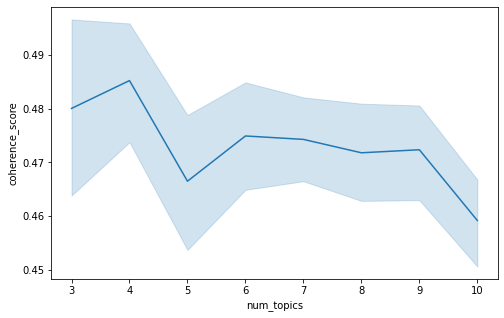

In [ ]:
plot_num_topics(duterte_tuned_model)

In [ ]:
duterte_tuned_model[duterte_tuned_model.num_topics ==4].sort_values(by='coherence_score', ascending=False).head()

,num_topics,alpha,iterations,coherence_score
17,4,0.1,250,0.518795
15,4,0.1,150,0.505946
23,4,0.4,300,0.505890
27,4,0.7,250,0.501811
18,4,0.1,300,0.499203


In [ ]:
duterte_best_model = build_lda_mallet_model(duterte_corpus, duterte_dict, 4, 0.1, 250)

In [ ]:
save_model(duterte_best_model, 'duterte_tuned_model')

In [ ]:
sotto_tuned_df = tune_model(sotto_corpus, sotto_dict, sotto_texts)

In [ ]:
sotto_tuned_df.head(3)

,num_topics,alpha,iterations,coherence_score
0,3,0.1,150,0.479877
1,3,0.1,200,0.512450
2,3,0.1,250,0.550339


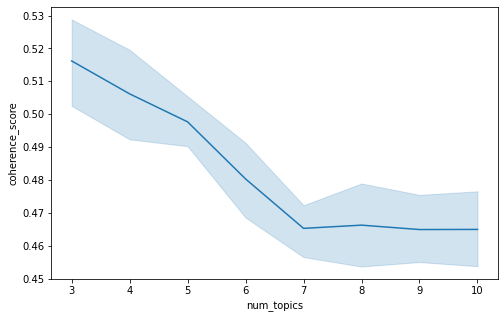

In [ ]:
plot_num_topics(sotto_tuned_df)

In [ ]:
sotto_tuned_df[sotto_tuned_df.num_topics ==3].sort_values(by='coherence_score', ascending=False).head()

,num_topics,alpha,iterations,coherence_score
4,3,0.1,350,0.556787
2,3,0.1,250,0.550339
6,3,0.4,200,0.549294
7,3,0.4,250,0.546593
12,3,0.7,250,0.538941


In [ ]:
sotto_best_model = build_lda_mallet_model(sotto_corpus, sotto_dict, 3, 0.1, 350)
save_model(sotto_best_model, 'sotto_tuned_model')

In [ ]:
bello_tuned_df = tune_model(bello_corpus, bello_dict, bello_texts)

In [ ]:
bello_tuned_df.head(3)

,num_topics,alpha,iterations,coherence_score
0,3,0.1,150,0.413341
1,3,0.1,200,0.431832
2,3,0.1,250,0.382859


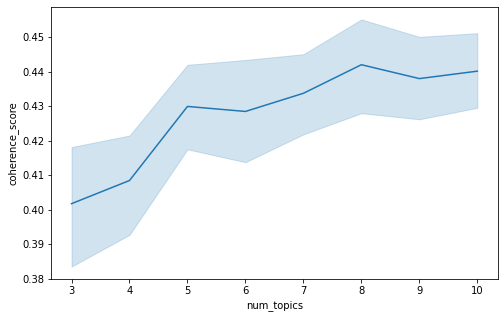

In [ ]:
plot_num_topics(bello_tuned_df)

In [ ]:
bello_tuned_df[bello_tuned_df.num_topics==8].sort_values(by='coherence_score', ascending=False).head()

,num_topics,alpha,iterations,coherence_score
84,8,0.4,350,0.490148
81,8,0.4,200,0.471287
76,8,0.1,200,0.468630
86,8,0.7,200,0.468089
77,8,0.1,250,0.456892


In [ ]:
bello_best_model = build_lda_mallet_model(bello_corpus, bello_dict, 8, 0.4, 350)
save_model(bello_best_model, 'bello_tuned_model')

In [ ]:
pangilinan_tuned_df = tune_model(pangilinan_corpus, pangilinan_dict, pangilinan_texts)

Streaming output truncated to the last 5000 lines.
1	0.01429	pangilinan senator kiko government francis country department philippine senate committee year farmer covid fund million budget time people program area 
2	0.01429	people president senator pangilinan law time year senate sen member day country life city election party philippine filipino power medium 
3	0.01429	people government day time statement country year pangilinan law drug president filipino administration job health countryman kiko war philippine case 
4	0.01429	president senator pangilinan case people kiko election court justice sen statement francis senate law party administration vote vice decision year 
5	0.01429	country day year people law family time today life kiko nation child pangilinan justice senator president farm philippine filipino world 
6	0.01429	time day people family law life year justice child peace support work today kiko nation government country pangilinan city president 

<50> LL/token: -8.19121

In [ ]:
pangilinan_tuned_df.head(3)

,num_topics,alpha,iterations,coherence_score
0,3,0.1,150,0.587879
1,3,0.1,200,0.587017
2,3,0.1,250,0.597198


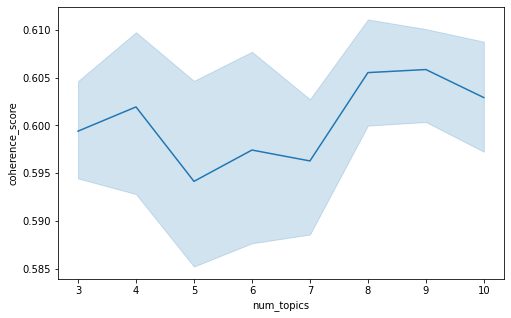

In [ ]:
plot_num_topics(pangilinan_tuned_df)

In [ ]:
pangilinan_tuned_df[pangilinan_tuned_df.num_topics==8].sort_values(by='coherence_score', ascending=False).head()

,num_topics,alpha,iterations,coherence_score
85,8,0.7,150,0.629936
84,8,0.4,350,0.618955
82,8,0.4,250,0.618577
86,8,0.7,200,0.612567
87,8,0.7,250,0.611453


In [ ]:
pangilinan_best_model = build_lda_mallet_model(pangilinan_corpus, pangilinan_dict,8, 0.7, 150)
save_model(pangilinan_best_model, 'pangilinan_tuned_model_5_8')

Mallet LDA: 8 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 393
total tokens: 154367
<10> LL/token: -8.83556
<20> LL/token: -8.42695
<30> LL/token: -8.24602
<40> LL/token: -8.15783

0	0.0875	day time school child today year health home farm country month family disease work people comelec number teacher test student 
1	0.0875	farmer law bill government act year support people filipino coconut development day income food life job work senate congress sen 
2	0.0875	family day time year morning child salamat birthday sharon_cuneta team love christmas support today friend campaign sharon visit story question 
3	0.0875	farmer food price country rice agriculture time government income sector year kiko people pangilinan market support farm program job philippine 
4	0.0875	people country nation filipino life democracy freedom president today time philippine day year pangilinan world family leader fight law child 
5	0.0875	justice senator case law pangilinan court statement pres

In [ ]:
atienza_tuned_df = tune_model(atienza_corpus, atienza_dict, atienza_texts)

In [ ]:
atienza_tuned_df.head(3)

,num_topics,alpha,iterations,coherence_score
0,3,0.1,150,0.517893
1,3,0.1,200,0.516683
2,3,0.1,250,0.542107


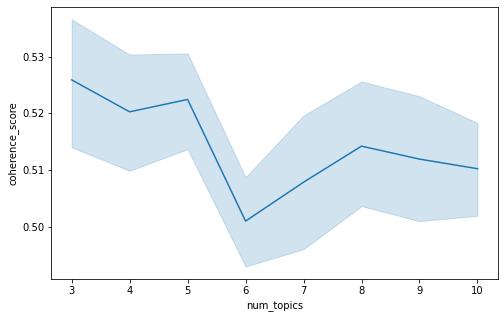

In [ ]:
plot_num_topics(atienza_tuned_df)

In [ ]:
atienza_tuned_df[atienza_tuned_df.num_topics==5].sort_values(by='coherence_score', ascending=False).head()

,num_topics,alpha,iterations,coherence_score
38,5,0.4,300,0.560227
32,5,0.1,250,0.540509
43,5,0.7,300,0.538683
33,5,0.1,300,0.532486
31,5,0.1,200,0.529546


In [ ]:
atienza_best_model = build_lda_mallet_model(atienza_corpus, atienza_dict, 5, 0.4, 300)
save_model(atienza_best_model, 'atienza_tuned_model')

In [ ]:
ong_df.shape, duterte_df.shape, sotto_df.shape, bello_df.shape, pangilinan_df.shape, atienza_df.shape

((5023, 11), (735, 11), (1203, 11), (380, 11), (13362, 11), (1558, 11))

In [ ]:
# start, limit, step = 3, 10, 1
# ong_models, ong_coherence_scores = model_num_topics(ong_corpus, ong_dict, ong_texts, start, limit, step)
# duterte_models, duterte_coherence_scores = model_num_topics(duterte_corpus, duterte_dict, duterte_texts, start, limit, step)
# sotto_models, sotto_coherence_scores = model_num_topics(sotto_corpus, sotto_dict, sotto_texts, start, limit, step)
# bello_models, bello_coherence_scores = model_num_topics(bello_corpus, bello_dict, bello_texts, start, limit, step)
# pangilinan_models, pangilinan_coherence_scores = model_num_topics(pangilinan_corpus, pangilinan_dict, pangilinan_texts, start, limit, step)
# atienza_models, atienza_coherence_scores = model_num_topics(atienza_corpus, atienza_dict, atienza_texts, start, limit, step)

In [ ]:
# vp_names = ['ong', 'duterte', 'sotto', 'bello', 'pangilinan', 'atienza']
# vp_coherence_scores = [ong_coherence_scores, duterte_coherence_scores, sotto_coherence_scores, bello_coherence_scores, pangilinan_coherence_scores, atienza_coherence_scores]

# num_topics = range(start, limit, step)

# plt.rcParams['figure.figsize'] = [17, 10]

# for i in range(len(vp_names)):
#   plt.subplot(2, 3, i+1)
#   plt.plot(num_topics, vp_coherence_scores[i])
#   plt.xlabel("Num Topics")
#   plt.ylabel("Coherence score")
#   plt.legend(("coherence_values"), loc='best')
#   plt.title(vp_names[i])
# plt.show()

In [ ]:
# candidate_best_models = [ong_best_model, duterte_best_model, sotto_best_model, bello_best_model, pangilinan_best_model, atienza_best_model]
# vp_candidate_models = dict(zip(vp_names, candidate_best_models))

# for candidate_name, candidate_model in vp_candidate_models.items():
#   save_model(candidate_model, candidate_name)

In [ ]:
candidate_models = []
vp_names = ['ong_tuned_model', 'duterte_tuned_model', 'sotto_tuned_model', 'bello_tuned_model', 'pangilinan_tuned_model', 'atienza_tuned_model']

for candidate_name in vp_names:
  candidate_model = load_model(candidate_name)
  candidate_models.append(candidate_model)
candidate_models

## Topic Understanding

### Find topic in each document

In [ ]:
def display_topics(model):
  topics = [[(term, round(wt, 3)) for term, wt in model.show_topic(n, topn=20)] for n in range(0, model.num_topics)]
  
  # set column width
  pd.set_option('display.max_colwidth', -1)
  topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Words per Topic'], index=['Topic_'+str(t) for t in range(1, model.num_topics+1)] )
  return topics_df

In [ ]:
# ong_df_topic = display_topics(ong_best_model)
# duterte_df_topic = display_topics(duterte_best_model)
# sotto_df_topic = display_topics(sotto_best_model)
# bello_df_topic = display_topics(bello_best_model)
pangilinan_df_topic = display_topics(pangilinan_best_model)
# atienza_df_topic = display_topics(atienza_best_model)

In [ ]:
def display_wordcloud(df_topic, rows, cols, fig_size):

  # initiate wordcloud object
  wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

  # set the figure size
  plt.rcParams['figure.figsize'] = fig_size

  # Create subplots for each topic
  for i in range(df_topic.shape[0]):

      wc.generate(text=df_topic["Words per Topic"][i])
      
      plt.subplot(rows, cols, i+1)
      plt.imshow(wc, interpolation="bilinear")
      plt.axis("off")
      plt.title(df_topic.index[i])

  plt.show()

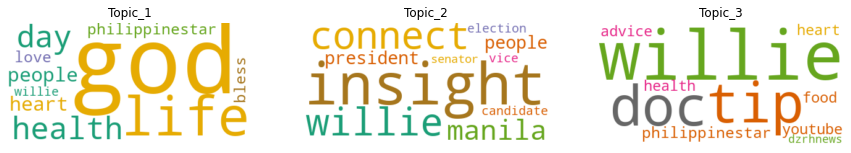

In [ ]:
display_wordcloud(ong_df_topic, 1, 3, [15,5])

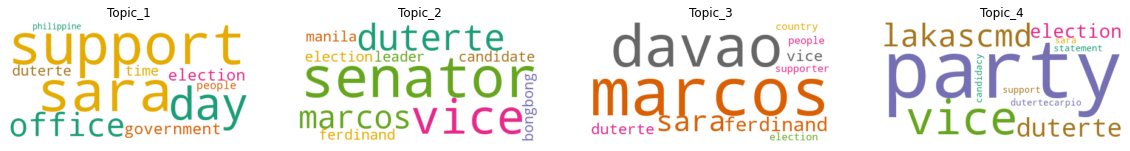

In [ ]:
display_wordcloud(duterte_df_topic, 1, 4, [20, 5])

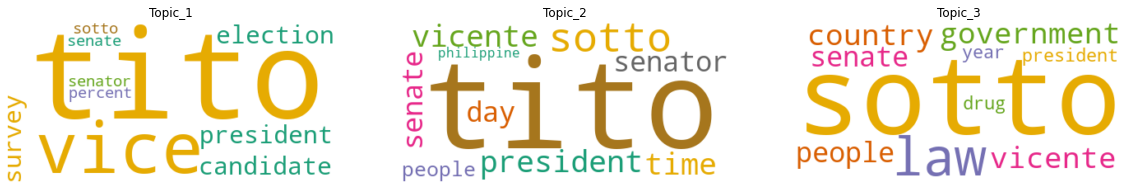

In [ ]:
display_wordcloud(sotto_df_topic, 1, 3, [20, 5])

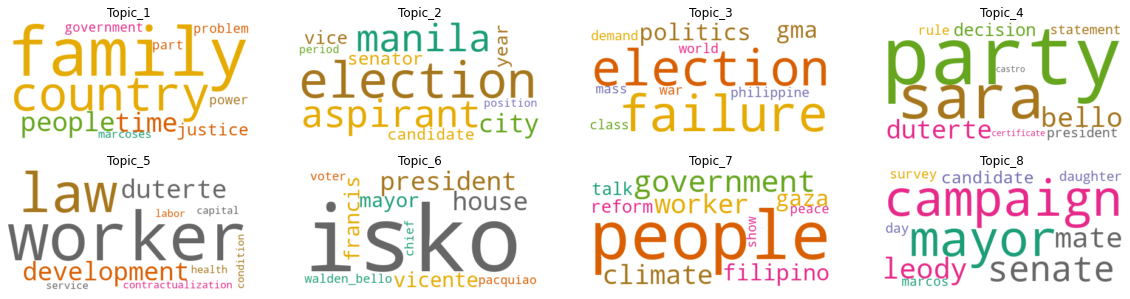

In [ ]:
display_wordcloud(bello_df_topic, 2, 4, [20, 5])

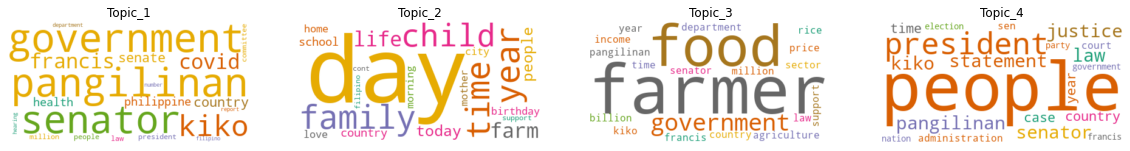

In [ ]:
display_wordcloud(pangilinan_df_topic, 2, 4, [20, 5])

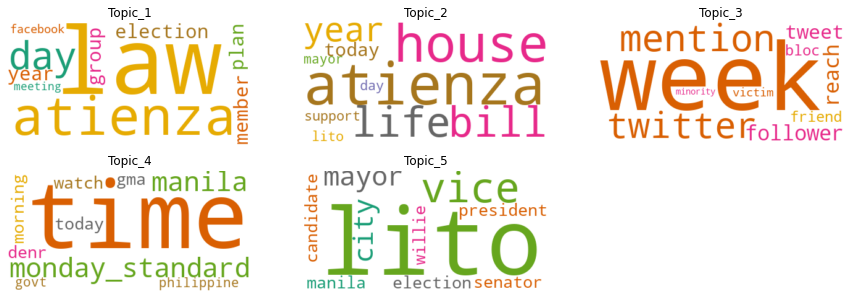

In [ ]:
display_wordcloud(atienza_df_topic, 2, 3, [15,5])

### Find Dominant Topic For Each Doc

In [ ]:
def create_df_dominant_topic(model, corpus, df_topic, candidate_df):
  vector = model[corpus]
  corpus_topics = [sorted(topic, key=lambda record: -record[1])[0] for topic in vector]

  # create a dataframe
  corpus_topic_df = pd.DataFrame()

  corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
  corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
  corpus_topic_df['Keywords'] = [df_topic.iloc[t[0]]['Words per Topic'] for t in corpus_topics]
  corpus_topic_df['content'] = candidate_df['lemma_text']

  return corpus_topic_df

In [ ]:
ong_dominant_topic = create_df_dominant_topic(ong_best_model, ong_corpus, ong_df_topic, ong_df)
ong_dominant_topic.head()

,Dominant Topic,Contribution %,Keywords,content
0,2,7.63,"philippinestar, dzrhnews, water, cancer, drink, prevention, lung, glass, measles, heat, victim, difficulty, visit, rabies, phl","[sign, cancer, tuberculosis, tip, jeffrey, monte, doctor, doc, willie]"
1,3,10.20,"willie, ong, video, tip, share, watch, cardiologist, treatment, article, covid, friend, home_remedy, cardiologist_panoorin, diarrhea, news","[senyales, tip, willie, cardiologist, panoorin, video]"
2,3,10.61,"willie, ong, video, tip, share, watch, cardiologist, treatment, article, covid, friend, home_remedy, cardiologist_panoorin, diarrhea, news","[senyales, tip, willie, cardiologist, panoorin, video]"
3,3,10.83,"willie, ong, video, tip, share, watch, cardiologist, treatment, article, covid, friend, home_remedy, cardiologist_panoorin, diarrhea, news","[treatment, diabetes, tip, endocrinologist, doc, willie, cardiologistinternist, watch, video]"
4,3,13.16,"willie, ong, video, tip, share, watch, cardiologist, treatment, article, covid, friend, home_remedy, cardiologist_panoorin, diarrhea, news","[heartburn, indigestion, home, remedy, sakit, tip, willie, cardiologist]"


In [ ]:
duterte_dominant_topic = create_df_dominant_topic(duterte_best_model, duterte_corpus, duterte_df_topic, duterte_df)
duterte_dominant_topic.head()

,Dominant Topic,Contribution %,Keywords,content
0,9,17.68,"drug, family, manila, leader, dutertes, government, marcos, philippine, case, war, bongbong, sen, ferdinand, administration, time","[today, drug, test, substance, request, uniteam, partner, senator, bongbong, support, call, transparency, official, trust, filipino, bbmsaras]"
1,4,12.73,"substitution, people, certificate, year, decision, dutertes, commission, election, law, post, run, bid, politics, october, poll","[thank, senator, bato, dela, rosa, advice, word, wisdom]"
2,2,13.68,"presidency, term, marcos, sara, power, voter, position, fact, vice, day, candidate, politician, opposition, candidacy, part","[sunday, god, bless, closeddoor, meeting, inside, inday, hotel, room, attendance, marcos, imee, side, wall, around, hour, minute]"
3,9,11.54,"drug, family, manila, leader, dutertes, government, marcos, philippine, case, war, bongbong, sen, ferdinand, administration, time","[birthday, jig]"
4,3,18.21,"marcos, ferdinand, pilipinas, bongbong, philippine, mayor, election, tandem, davao, city, sara, senator, candidate, dutertecarpio, support","[salamat, lipad, agila, movement, volunteerism, ipagpatuloy, gawain, pilipinas, official, video, support, mayor, inday, sara, duterte, president, philippine, election, studio, city, clip, photo]"


In [ ]:
sotto_dominant_topic = create_df_dominant_topic(sotto_best_model, sotto_corpus, sotto_df_topic, sotto_df)
sotto_dominant_topic.head()

,Dominant Topic,Contribution %,Keywords,content
0,3,12.12,"election, tito, senator, candidate, survey, vice, duterte, aspirant, percent, manila, mayor, voter, candidacy, vote, poll","[tito, sotto, sen, mayor, vico]"
1,10,19.83,"people, program, government, problem, budget, senate, thing, support, president, system, money, billion, agency, effort, community","[service, activity, people, support, system, reduction, stress, health, time, mahalagang, pangalagaan, pamahalaan, vicente, tito, sotto]"
2,5,12.99,"party, campaign, post, position, sen, presidency, heart, politics, child, issue, show, period, talk, father, vice","[love, vicente, tito, sottoand, mr, helengamboa, sotto, show, affection, towards]"
3,2,13.69,"vicente, sotto, president, senate, iii, time, senator, tito, leader, city, filipino, philippine, situation, province, part","[vicente, tito, member, group, evangelicals, city]"
4,2,11.93,"vicente, sotto, president, senate, iii, time, senator, tito, leader, city, filipino, philippine, situation, province, part","[spending, time, apo, sunday]"


In [ ]:
bello_dominant_topic = create_df_dominant_topic(bello_best_model, bello_corpus, bello_df_topic, bello_df)
bello_dominant_topic.head()

,Dominant Topic,Contribution %,Keywords,content
0,12,52.83,"comelec, commission, bello, castro, party, sara, bong, substitution, certificate, substitute, matter, pilipino, castillo, harry, statement","[manila, president, rodrigo, roa, duterte, daughter, sara, christopher, bong, among, aspirant, certificate, substitute, position, poll, data, commission, election, individual, cocs, filing, coc, october, file, senator, visorde, pederalismo, dugong, dakilang, samahan, day, statement, substitution, comelec, office, intramuros, monday, term, bid, city, mayor, another, vice, muslim, democrat, hand, grepor, belgica, withdrawal, capella, velasco, lakascmd, orlando, partido, masang, pilipino, bello, candidate, raquel, castillo, lakas, masa, others, bienvenido, lorque, katipunan, demokratikong, joel, sison, kilusang, bagong, benedicto, jose, pdds, valdez, manuel, castro, joseph, peter, aksyon, demokratiko, guillermo, lorenzo, eleazar, reporma, pdr, redemptus, andres, jesus, people, party, herminio, harry, roque, paolo, mario, martelino, ross, jocson, cruz, ...]"
1,3,30.51,"election, president, candidate, vice, city, country, manila, mayor, year, aspirant, list, senator, candidacy, poll, leody","[manila, partido, lakas, masa, vice, walden, bello, philippine, state, teach, university, arrival, labor, leader, aspirant, leody, election, hell, marcosduterte, axis, news, compliance, health, protocol, hotel, city, spokesperson, leomar, doctolero, traveler, country, quarantine, release, rtpcr, test, day, read, afterwards, home, national, accommodation, six, adjunct, professor, sociology, york, binghamton, raquel, castillo, candidacy, president, activist, mate, lawmaker, among, next, year, willie, buhay, rep, lito, senator, tito, sotto, davao, mayor, list, month, candidate, campaign, period, position, video]"
2,10,48.86,"time, policy, solution, contractualization, duterte, center, platform, bayan, debate, manifestation, wealth, detail, system, tito, head","[manila, vice, walden, bello, tuesday, election, rival, policy, theatrics, campaign, press, conference, corruption, poll, voter, program, detail, behind, lagi, default, issue, tinututulan, government, adminstration, corrupt, kailangangkailangan, yan, reporter, duterte, administration, underline, pag, tiningnan, platform, nakakaawa, bayan, nung, sinasabi, interview, halo, problema, look, candidate, feel, people, presidentiables, whatever, intreviews, room, country, problem, labor, leader, leody, president, among, contractualization, wealth, tax, minimum, wage, worker, healthcare, mate, nang, todotodo, ekonomiya, pagbabahagi, lupa, land, reform, law, crisis, economy, programa, talagang, analysis, solution, makikita, ibang, tumatakbo, focus, time, criticism, marcoses, dutertes, anything, center, pagkawalang, hiya, dinastiyang, shamelessness, dynasty, bring, ought, power, respect, risk, machination, way, ...]"
3,9,58.29,"issue, campaign, worker, government, university, reform, focus, state, willie_buhay_rep_lito, reporter, farmer, york_binghamton, agriculture, massacre, benefit","[manila, vice, walden, bello, tuesday, would, redistribution, land, farmer, election, commemoration, violent, dispersal, protester, stop, measure, reform, hacienda, luisita, distribution, sale, proceeds, must, hectare, counter, binabawi, lupain, haciendero, programa, repeal, rice, tarrification, act, one, cause, misery, reporter, counterreform, hacienderos, transformation, countryside, benefit, philippine, labor, leader, atty, luke, espiritu, solidarity, victim, massacre, property, right, magkalaban, silay, kulay, magkakaiba, campaign, tshirt, pula, pink, mayroong, pang, magkakasama, case, issue, adversary, shirt, whatever, color, magkakampi, magsasaka, mangaggawa, kalaban, iemphasize, gustong, halalan, worker, opponent, elite, violence, testament, tragedy, peasant, example, nung, kanayunan, mambubukid, throughout, history, scholar, portion, country, agriculture, iniwan, forgotten, government, rodrigo, duterte, aspirant, .

In [ ]:
pangilinan_dominant_topic = create_df_dominant_topic(pangilinan_best_model, pangilinan_corpus, pangilinan_df_topic, pangilinan_df)
pangilinan_dominant_topic.head()

,Dominant Topic,Contribution %,Keywords,content
0,7,12.16,"pangilinan, kiko, senator, time, country, government, francis, today, people, nation, problem, support, effort, act, solution","[kiko, pangilinan, educator]"
1,6,13.98,"people, life, drug, democracy, power, sen, statement, administration, medium, freedom, war, party, year, police, fight","[magkasama, kabataan, chito, university, student, council, chairperson, councilor, news, break, heart, party, dami]"
2,6,13.56,"people, life, drug, democracy, power, sen, statement, administration, medium, freedom, war, party, year, police, fight","[daughter, frankie, earthworm, pit, makagawa, fertilizer, consume, decomposing, material, leaf]"
3,1,17.01,"child, family, day, farm, school, morning, cont, birthday, heart, love, watch, parent, salamat, mother, congratulation","[arigatou, gozamaisu, roanne, iwabuchi, kawaii, vibe, daughter, tandem, katropa, saitama, japan, talent, creativity, kakampinks]"
4,1,12.87,"child, family, day, farm, school, morning, cont, birthday, heart, love, watch, parent, salamat, mother, congratulation","[level, exclusive, host, ferrer, episode, sen, sharon, cunetapangilinan, simulcast, youtubecomradyokatipunanfm, audio, streaming, jescomphradyokatipunan]"


In [ ]:
atienza_dominant_topic = create_df_dominant_topic(atienza_best_model, atienza_corpus, atienza_df_topic, atienza_df)
atienza_dominant_topic.head()

,Dominant Topic,Contribution %,Keywords,content
0,15,8.44,"time, monday_standard, solon, session, bloc, beatbeatrice, office_environment_compliance, mannypacquiao, set_record, certificate_resort, belmonte, rule, quorum, award, via_inquirerdotnet","[monday, standard, time]"
1,15,8.65,"time, monday_standard, solon, session, bloc, beatbeatrice, office_environment_compliance, mannypacquiao, set_record, certificate_resort, belmonte, rule, quorum, award, via_inquirerdotnet","[monday, standard, time]"
2,15,8.65,"time, monday_standard, solon, session, bloc, beatbeatrice, office_environment_compliance, mannypacquiao, set_record, certificate_resort, belmonte, rule, quorum, award, via_inquirerdotnet","[monday, standard, time]"
3,15,8.65,"time, monday_standard, solon, session, bloc, beatbeatrice, office_environment_compliance, mannypacquiao, set_record, certificate_resort, belmonte, rule, quorum, award, via_inquirerdotnet","[monday, standard, time]"
4,15,8.65,"time, monday_standard, solon, session, bloc, beatbeatrice, office_environment_compliance, mannypacquiao, set_record, certificate_resort, belmonte, rule, quorum, award, via_inquirerdotnet","[monday, standard, time]"


## Visualization with pyLDAvis

In [ ]:
ong_model = load_model('ong')
duterte_model = load_model('duterte')
sotto_model = load_model('sotto')
bello_model = load_model('bello')
pangilinan_model = load_model('pangilinan')
atienza_model = load_model('atienza')

In [ ]:
from gensim.models.ldamodel import LdaModel

def convert_mallet_to_lda(mallet_model):
    lda_model = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics, alpha=mallet_model.alpha) 
    lda_model.state.sstats[...] = mallet_model.wordtopics
    lda_model.sync_state()
    return lda_model

In [ ]:
ong_lda_model = convert_mallet_to_lda(ong_model)
duterte_lda_model = convert_mallet_to_lda(duterte_model)
sotto_lda_model = convert_mallet_to_lda(sotto_model)
bello_lda_model = convert_mallet_to_lda(bello_model)
pangilinan_lda_model = convert_mallet_to_lda(pangilinan_model)
atienza_lda_model = convert_mallet_to_lda(atienza_model)

In [ ]:
ong_vis = gensimvis.prepare(ong_lda_model, ong_corpus, ong_dict)
duterte_vis = gensimvis.prepare(duterte_lda_model, duterte_corpus, duterte_dict)
sotto_vis = gensimvis.prepare(sotto_lda_model, sotto_corpus, sotto_dict)
bello_vis = gensimvis.prepare(bello_lda_model, bello_corpus, bello_dict)
pangilinan_vis = gensimvis.prepare(pangilinan_lda_model, pangilinan_corpus, pangilinan_dict)
atienza_vis = gensimvis.prepare(atienza_lda_model, atienza_corpus, atienza_dict)

In [ ]:
ong_html = pyLDAvis.prepared_data_to_html(ong_vis)
duterte_html = pyLDAvis.prepared_data_to_html(duterte_vis)
sotto_html = pyLDAvis.prepared_data_to_html(sotto_vis)
bello_html = pyLDAvis.prepared_data_to_html(bello_vis)
pangilinan_html = pyLDAvis.prepared_data_to_html(pangilinan_vis)
atienza_html = pyLDAvis.prepared_data_to_html(atienza_vis)

In [ ]:
atienza_html

'\n<link rel="stylesheet" type="text/css" href="https://cdn.jsdelivr.net/gh/bmabey/pyLDAvis@3.3.1/pyLDAvis/js/ldavis.v1.0.0.css">\n\n\n<div id="ldavis_el56601403040104523046233580507"></div>\n<script type="text/javascript">\n\nvar ldavis_el56601403040104523046233580507_data = {"mdsDat": {"x": [0.36835792703152676, 0.05092977956463776, -0.04204212142678444, 0.045299680630602315, -0.006009325091635073, -0.06992110789150865, -0.0332338584633505, -0.05649724216336258, 0.04646207586600218, -0.027355165284589963, -0.06980555955882188, -0.09212557723960522, 0.03420340812392771, -0.02406389364474482, -0.07039598829162722, -0.045460895620508215, 0.06685942419314554, -0.015257091059134042, -0.017815284030672587, -0.04212918564349647], "y": [0.03391389585343814, -0.1789129526999602, -0.002064493719214599, -0.08079105492087248, -0.1992469995177345, -0.10741473346442434, -0.0001399679383734577, 0.11007988643817614, 0.03734254637649132, -0.026172333582915288, 0.002052644215163345, -0.010071091406808

## Streamlit HTML

In [ ]:
import os

os.chdir('/content/drive/MyDrive/Omdena/Philippines/Politician/App')

!pwd

/content/drive/MyDrive/Omdena/Philippines/Politician/App


In [ ]:
%%writefile app.py

import streamlit as st
from streamlit import components
import pickle
import pandas as pd

# import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

# import pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
# pyLDAvis.enable_notebook()

st.set_page_config(layout="wide")

vice_pres = ['Willie Ong','Sara Duterte', 'Vicente Sotto III', 'Walden Bello','Francis Pangilinan', 'Lito Atienza']
text_path = '/content/drive/MyDrive/Omdena/Philippines/Politician/Data/data_processed_translated.csv'

def load_model(model_name):
  model = pickle.load(open(f"/content/drive/MyDrive/Omdena/Philippines/Politician/Models/Pkl/{model_name}.pkl", "rb"))
  return model

def read_file(path):
  df = pd.read_csv(path)
  df = df[~df.lemma_text_flatten.isna()]
  df = df.drop('lemma_text', axis=1)
  df['lemma_text'] = df.lemma_text_flatten.apply(lambda x: [text for text in str(x).split()])
  return df

def get_candidate_data(vice_pres_list, df):
  df_list = {}
  for candidate in vice_pres_list:
    candidate_df = df[df.candidate == candidate]
    candidate_df = candidate_df.reset_index(drop=True)
    df_list[candidate] = candidate_df
  return df_list

def create_bigrams(texts):
  # Build the bigram model
  bigram = models.Phrases(texts, min_count=5, threshold=100) # higher threshold fewer phrases.

  # Faster way to get a sentence clubbed as a bigram
  bigram_model = models.phrases.Phraser(bigram)

  return [bigram_model[doc] for doc in texts]

def create_trigrams(texts):
  # Build the trigram models
  trigram = models.Phrases(texts, threshold=100)  

  trigram_model = models.phrases.Phraser(trigram)

  return [trigram_model[doc] for doc in texts]

def processed_trigram(text):
  bigram_texts = create_bigrams(text)
  trigram_texts = create_trigrams(bigram_texts)

  return trigram_texts

def create_dict_corpus(texts):
  dictionary = corpora.Dictionary(texts)
  dictionary.filter_extremes(no_below=5, no_above=0.7)
  corpus = [dictionary.doc2bow(text) for text in texts]
  return dictionary, corpus

def convert_mallet_to_lda(mallet_model):
    lda_model = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics, alpha=mallet_model.alpha) 
    lda_model.state.sstats[...] = mallet_model.wordtopics
    lda_model.sync_state()
    return lda_model

def processed_candidate_topics(candidate_data, selected_vp, vp_model_name):
  vp_df = candidate_data[selected_vp]
  vp_texts = processed_trigram(list(vp_df['lemma_text']))
  vp_dict, vp_corpus = create_dict_corpus(vp_texts)

  vp_mallet_model = load_model(vp_model_name)
  vp_lda_model = convert_mallet_to_lda(vp_mallet_model)

  vp_vis = gensimvis.prepare(vp_lda_model, vp_corpus, vp_dict)
  html_string = pyLDAvis.prepared_data_to_html(vp_vis)
  components.v1.html(html_string, height=800, scrolling=True)

def app():

  vp_names = ['Willie Ong','Sara Duterte', 'Vicente Sotto III', 'Walden Bello', 'Lito Atienza'] # 'Francis Pangilinan',
  vp_model_names = ['ong_tuned_model', 'duterte_tuned_model', 'sotto_tuned_model', 'bello_tuned_model', 'atienza_tuned_model'] # 'pangilinan_tuned_model', 

  vp_dict = dict(zip(vp_names, vp_model_names))

  df = read_file(text_path)
  candidate_data = get_candidate_data(vice_pres, df)

  selected_vp = st.sidebar.selectbox('Choose Vice Presidential Candidate', ('Willie Ong','Sara Duterte', 'Vicente Sotto III', 'Walden Bello','Lito Atienza')) # 'Francis Pangilinan', 

  vp_model_name = vp_dict[selected_vp]
  processed_candidate_topics(candidate_data, selected_vp, vp_model_name)


if __name__ == '__main__':
  app()

Overwriting app.py


In [ ]:
 !streamlit run app.py & npx localtunnel --port 8501